# Object Detection using TAO YOLOv3

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080">


## Learning Objectives
In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Take a pretrained ResNet-18 model and train a ResNet-18 YOLO v3 model on the KITTI dataset
* Prune the trained YOLO v3 model
* Retrain the pruned model to recover lost accuracy
* Export the pruned model
* Quantize the pruned model using QAT
* Run Inference on the trained model
* Export the pruned, quantized and retrained model to a .etlt file for deployment to DeepStream
* Run inference on the exported. etlt model to verify deployment using TensorRT

## Table of Contents

This notebook shows an example usecase of YOLO v3 object detection using Train Adapt Optimize (TAO) Toolkit.

0. [Set up env variables and map drives](#head-0)
1. [Install the TAO launcher](#head-1)
2. [Prepare dataset and pre-trained model](#head-2) <br>
     2.1 [Download the dataset](#head-2-1)<br>
     2.2 [Verify the downloaded dataset](#head-2-2)<br>
     2.4 [Prepare the datasets for training and validation](#head-2-3)<br>
     2.3 [Download pretrained model](#head-2-4)
3. [Provide training specification](#head-3)
4. [Run TAO training](#head-4)
5. [Evaluate trained models](#head-5)
6. [Prune trained models](#head-6)
7. [Retrain pruned models](#head-7)
8. [Evaluate retrained model](#head-8)
9. [Visualize inferences](#head-9)
10. [Model Export](#head-10)
11. [Verify deployed model](#head-11)

## 1. Set up env variables and map drives<a class="anchor" id="head-0"></a>

When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users workspace. Please note that the dataset to run this notebook is expected to reside in the `$LOCAL_PROJECT_DIR/data`, while the TAO experiment generated collaterals will be output to `$LOCAL_PROJECT_DIR/yolo_v3`. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

In [1]:
# Setting up env variables for cleaner command line commands.
import os

print("Please replace the variable with your key.")
%env KEY=nvidia_tlt
%env USER_EXPERIMENT_DIR=/workspace/tao-experiments/yolo_v3
%env DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tao-samples/yolo_v3

# Please define this local project directory that needs to be mapped to the TAO docker session.
# The dataset expected to be present in $LOCAL_PROJECT_DIR/data, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/yolo_v3
%env LOCAL_PROJECT_DIR= /home/ubuntu/cv_samples_v1.2.0/yolo_v3
os.environ["LOCAL_DATA_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "data")
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "yolo_v3")

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)
%env SPECS_DIR=/workspace/tao-experiments/yolo_v3/specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

Please replace the variable with your key.
env: KEY=nvidia_tlt
env: USER_EXPERIMENT_DIR=/workspace/tao-experiments/yolo_v3
env: DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
env: LOCAL_PROJECT_DIR=/home/ubuntu/cv_samples_v1.2.0/yolo_v3
env: SPECS_DIR=/workspace/tao-experiments/yolo_v3/specs
total 32
-rw-rw-r-- 1 ubuntu ubuntu 2199 Aug 24 23:51 yolo_v3_train_resnet18_kitti.txt
-rw-rw-r-- 1 ubuntu ubuntu  302 Oct 19 01:12 yolo_v3_tfrecords_kitti_synth_test.txt
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct 19 01:35 archive
-rw-rw-r-- 1 ubuntu ubuntu 2257 Oct 19 02:04 yolo_v3_train_resnet18_kitti_synth.txt
-rw-rw-r-- 1 ubuntu ubuntu  321 Oct 19 10:24 yolo_v3_tfrecords_kitti_synth_train.txt
-rw-rw-r-- 1 ubuntu ubuntu  293 Oct 19 10:25 yolo_v3_tfrecords_kitti_real_test.txt
-rw-rw-r-- 1 ubuntu ubuntu  317 Oct 19 10:25 yolo_v3_tfrecords_kitti_real_train.txt
-rw-rw-r-- 1 ubuntu ubuntu 2222 Oct 19 10:48 yolo_v3_train_resnet18_kitti_synth_fine_tuned.txt


The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from outside to inside of the docker instance.

In [2]:
# Mapping up the local directories to the TAO docker.
import json
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tao-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ],
    # Update if you prefer to use a different GPU in multi-GPU systems
    "Envs": [
        {
            "variable": "CUDA_VISIBLE_DEVICES",
            "value": "0"
        }
    ],
    # Update based on your system's available resources
    "DockerOptions": {
        "shm_size": "16G",
        "ulimits": {
            "memlock": -1,
            "stack": 67108864
        },
        "user": "1000:1000"
    }
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

In [3]:
!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/ubuntu/cv_samples_v1.2.0/yolo_v3",
            "destination": "/workspace/tao-experiments"
        },
        {
            "source": "/home/ubuntu/cv_samples_v1.2.0/yolo_v3/specs",
            "destination": "/workspace/tao-experiments/yolo_v3/specs"
        }
    ],
    "Envs": [
        {
            "variable": "CUDA_VISIBLE_DEVICES",
            "value": "0"
        }
    ],
    "DockerOptions": {
        "shm_size": "16G",
        "ulimits": {
            "memlock": -1,
            "stack": 67108864
        },
        "user": "1000:1000"
    }
}

In [5]:
# View the versions of the TAO launcher
!tao info --verbose

Configuration of the TAO Toolkit Instance

dockers: 		
	nvidia/tao/tao-toolkit-tf: 			
		docker_registry: nvcr.io
		docker_tag: v3.21.08-py3
		tasks: 
			1. augment
			2. bpnet
			3. classification
			4. detectnet_v2
			5. dssd
			6. emotionnet
			7. faster_rcnn
			8. fpenet
			9. gazenet
			10. gesturenet
			11. heartratenet
			12. lprnet
			13. mask_rcnn
			14. multitask_classification
			15. retinanet
			16. ssd
			17. unet
			18. yolo_v3
			19. yolo_v4
			20. converter
	nvidia/tao/tao-toolkit-pyt: 			
		docker_registry: nvcr.io
		docker_tag: v3.21.08-py3
		tasks: 
			1. speech_to_text
			2. speech_to_text_citrinet
			3. text_classification
			4. question_answering
			5. token_classification
			6. intent_slot_classification
			7. punctuation_and_capitalization
	nvidia/tao/tao-toolkit-lm: 			
		docker_registry: nvcr.io
		docker_tag: v3.21.08-py3
		tasks: 
			1. n_gram
format_version: 1.0
toolkit_version: 3.21.08
published_date: 08/17/2021


 ## 2. Download and Prepare dataset

Create a data folder inside the root directory and download the synthetic and real datasets from the provided links.

Dataset is already formatted into train and test for both synthetic and real cases. 

We have 2 scenarios in the dataset i.e dataset with less complex background and dataset with complex background.


Following directory structure will be there according to the spec files. 

├── real_test
├── real_train_20
├── synthetic_test
├── synthetic_train


## 3 Prepare tfrecords from kitti format dataset <a class="anchor" id="head-2-3"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the dataset_convert 
* TFRecords only need to be generated once.

Either TFRecord dataset format or the raw KITTI format(with directories of images and KITTI labels) can be used for training/validation. TFRecord dataset format is the recommended one as it is generally faster than reading numerious KITTI label files. However, in some cases, especially when training with small resolutions like 416x416, the experimental result shows TFRecord dataset is almost the same or slightly slower than the other format. So by default, we will use TFRecord dataset in this notebook. As a reference, we still provide the spec files for raw KITTI dataset format.

In [13]:
# Creating a new directory for the output tfrecords dump.
# !mkdir -p $LOCAL_PROJECT_DIR/data
# KITTI trainval
!tao yolo_v3 dataset_convert -d $SPECS_DIR/yolo_v3_tfrecords_kitti_synth_train.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_synthetic_train/kitti_synthetic_train

!tao yolo_v3 dataset_convert -d $SPECS_DIR/yolo_v3_tfrecords_kitti_synth_test.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_synthetic_test/kitti_synthetic_test

2021-11-11 13:37:17,544 [INFO] root: Registry: ['nvcr.io']
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-h74jkkjw because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-11 13:37:24,947 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-11-11 13:37:24,971 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 10555	Val: 106
2021-11-11 13:37:24,971 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2021-11-11 13:37:24,977 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2021-11-11 13:37:24,

2021-11-11 13:38:07,447 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


In [14]:
# Creating a new directory for the output tfrecords dump.
# !mkdir -p $LOCAL_PROJECT_DIR/data
# KITTI trainval
!tao yolo_v3 dataset_convert -d $SPECS_DIR/yolo_v3_tfrecords_kitti_real_train.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_real_train_20/kitti_real_train_20

!tao yolo_v3 dataset_convert -d $SPECS_DIR/yolo_v3_tfrecords_kitti_real_test.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_real_test/kitti_real_test

2021-10-19 13:33:07,574 [INFO] root: Registry: ['nvcr.io']
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ns2ir6cf because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2021-10-19 13:33:16,283 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-10-19 13:33:16,284 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 194	Val: 1
2021-10-19 13:33:16,284 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2021-10-19 13:33:16,284 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2021-10-19 13:33:16,284 

2021-10-19 13:33:38,948 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


Additionally, if you have your own dataset already in a volume (or folder), you can mount the volume on `LOCAL_DATA_DIR` (or create a soft link). Below shows an example:
```bash
# if your dataset is in /dev/sdc1
mount /dev/sdc1 $LOCAL_DATA_DIR

# if your dataset is in folder /var/dataset
ln -sf /var/dataset $LOCAL_DATA_DIR
```

In [14]:
# If you use your own dataset, you will need to run the code below to generate the best anchor shape

# !tao yolo_v3 kmeans -l $DATA_DOWNLOAD_DIR/training/label_2 \
#                     -i $DATA_DOWNLOAD_DIR/training/image_2 \
#                     -n 9 \
#                     -x 1248 \
#                     -y 384

# The anchor shape generated by this script is sorted. Write the first 3 into small_anchor_shape in the config
# file. Write middle 3 into mid_anchor_shape. Write last 3 into big_anchor_shape.

 ## 4 NGC CLI Instalaltion & Download pre-trained model <a class="anchor" id="head-2-4"></a>

We will use NGC CLI to get the pre-trained models. For more details, go to [ngc.nvidia.com](ngc.nvidia.com) and click the SETUP on the navigation bar.

In [15]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2021-11-11 13:38:18--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 99.84.216.3, 99.84.216.116, 99.84.216.8, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|99.84.216.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25122135 (24M) [application/zip]
Saving to: ‘/home/ubuntu/cv_samples_v1.2.0/yolo_v3/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  23.96M   141MB/s    in 0.2s    

2021-11-11 13:38:18 (141 MB/s) - ‘/home/ubuntu/cv_samples_v1.2.0/yolo_v3/ngccli/ngccli_cat_linux.zip’ saved [25122135/25122135]

Archive:  /home/ubuntu/cv_samples_v1.2.0/yolo_v3/ngccli/ngccli_cat_linux.zip
  inflating: /home/ubuntu/cv_samples_v1.2.0/yolo_v3/ngccli/ngc  
 extracting: /home/ubuntu/cv_samples_v1.2.0/yolo_v3/ngccli/ngc.md5  


In [16]:
!ngc registry model list nvidia/tao/pretrained_object_detection:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 77.56 | 80    | 1     | V100  | 153.7 | 153.7 | UPLOA | Aug   |
|       |       |       |       |       |       | 2 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| vgg16 | 77.17 | 80    | 1     | V100  | 113.2 | 113.1 | UPLOA | Aug   |
|       |       |       |       |       |       | 6 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| squee | 65.13 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Aug   |
| zenet |       |       |       |     

In [17]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

In [18]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tao/pretrained_object_detection:resnet18 \
                    --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.38 MB in 6s, Download speed: 13.71 MB/s               
----------------------------------------------------
Transfer id: pretrained_object_detection_vresnet18 Download status: Completed.
Downloaded local path: /home/ubuntu/cv_samples_v1.2.0/yolo_v3/yolo_v3/pretrained_resnet18/pretrained_object_detection_vresnet18-1
Total files downloaded: 1 
Total downloaded size: 82.38 MB
Started at: 2021-11-11 13:38:23.699722
Completed at: 2021-11-11 13:38:29.710057
Duration taken: 6s
----------------------------------------------------


In [19]:
print("Check that model is downloaded into dir.")
!ls -l $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/pretrained_object_detection_vresnet18

Check that model is downloaded into dir.
total 91096
-rw------- 1 ubuntu ubuntu 93278448 Oct 19 01:47 resnet_18.hdf5


 ## 5. Provide training specification <a class="anchor" id="head-3"></a>

In [20]:
# Provide pretrained model path
!sed -i 's,EXPERIMENT_DIR,'"$USER_EXPERIMENT_DIR"',' $LOCAL_SPECS_DIR/yolo_v3_train_resnet18_kitti_synth.txt

# To enable QAT training on sample spec file, uncomment following lines
# !sed -i "s/enable_qat: false/enable_qat: true/g" $LOCAL_SPECS_DIR/yolo_v3_train_resnet18_tfrecord.txt
# !sed -i "s/enable_qat: false/enable_qat: true/g" $LOCAL_SPECS_DIR/yolo_v3_retrain_resnet18_tfrecord.txt

In [22]:
!cat $LOCAL_SPECS_DIR/yolo_v3_train_resnet18_kitti_synth.txt

random_seed: 42
yolov3_config {
  big_anchor_shape: "[(114.94, 60.67), (159.06, 114.59), (297.59, 176.38)]"
  mid_anchor_shape: "[(42.99, 31.91), (79.57, 31.75), (56.80, 56.93)]"
  small_anchor_shape: "[(15.60, 13.88), (30.25, 20.25), (20.67, 49.63)]"
  matching_neutral_box_iou: 0.7
  arch: "resnet"
  nlayers: 18
  arch_conv_blocks: 2
  loss_loc_weight: 0.8
  loss_neg_obj_weights: 100.0
  loss_class_weights: 1.0
  freeze_bn: false
  #freeze_blocks: 0
  force_relu: false
}
training_config {
  batch_size_per_gpu: 4
  num_epochs: 80
  enable_qat: false
  checkpoint_interval: 10
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 1e-6
    max_learning_rate: 1e-4
    soft_start: 0.1
    annealing: 0.5
    }
  }
  regularizer {
    type: L1
    weight: 3e-5
  }
  optimizer {
    adam {
      epsilon: 1e-7
      beta1: 0.9
      beta2: 0.999
      amsgrad: false
    }
  }
  pretrain_model_path: "/workspace/tao-experiments/yolo_v3/pretrained_resnet18/pretrained_object_de

In [23]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/resnet18_synth_fine_tuned_amp16

 ## 6. Run TAO training on Synthetic Dataset<a class="anchor" id="head-4"></a>
 * Provide the sample spec file for training.

In [24]:
print("To run with multigpu, please change --gpus based on the number of available GPUs in your machine.")
!tao yolo_v3 train -e $SPECS_DIR/yolo_v3_train_resnet18_kitti_synth.txt \
                   -r $USER_EXPERIMENT_DIR/resnet18_synth_amp16 \
                   -k $KEY \
                   --gpus 1 \
                   --use_amp > out_resnet18_synth_amp16.log

To run with multigpu, please change --gpus based on the number of available GPUs in your machine.
2021-11-11 13:38:30,872 [INFO] root: Registry: ['nvcr.io']
2021-11-12 00:03:35,228 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


##### print("To resume from checkpoint, please change pretrain_model_path to resume_model_path in config file.")

In [33]:
print('Model for each epoch:')
print('---------------------')
!ls -ltrh $LOCAL_EXPERIMENT_DIR/resnet18_synth_amp16/weights

Model for each epoch:
---------------------
total 1.8G
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 03:17 yolov3_resnet18_epoch_010.tlt
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 04:01 yolov3_resnet18_epoch_020.tlt
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 04:40 yolov3_resnet18_epoch_030.tlt
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 05:19 yolov3_resnet18_epoch_040.tlt
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 05:58 yolov3_resnet18_epoch_050.tlt
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 06:37 yolov3_resnet18_epoch_060.tlt
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 07:16 yolov3_resnet18_epoch_070.tlt
-rw-r--r-- 1 ubuntu ubuntu 220M Oct 19 07:55 yolov3_resnet18_epoch_080.tlt


In [36]:
# # Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
# !cat $LOCAL_EXPERIMENT_DIR/resnet18_synth_amp16/yolov3_training_log_resnet18.csv
# %set_env EPOCH=080

 ## 7. Evaluate trained models Synthetic Dataset <a class="anchor" id="head-5"></a>

In [35]:
!tao yolo_v3 evaluate -e $SPECS_DIR/yolo_v3_train_resnet18_kitti_synth.txt \
                      -m $USER_EXPERIMENT_DIR/resnet18_synth_amp16/weights/yolov3_resnet18_epoch_$EPOCH.tlt \
                      -k $KEY

2021-10-19 10:13:05,502 [INFO] root: Registry: ['nvcr.io']
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-do73y22d because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2021-10-19 10:13:12,253 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-10-19 10:13:12,253 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.


2021-10-19 10:13:12,256 [WARNING] tensorflow: From /usr/local/lib/pytho

yolo_conv3_3 (Conv2D)           (None, 128, 32, 32)  32768       yolo_conv3_2_lrelu[0][0]         
__________________________________________________________________________________________________
yolo_conv3_3_bn (BatchNormaliza (None, 128, 32, 32)  512         yolo_conv3_3[0][0]               
__________________________________________________________________________________________________
yolo_conv3_3_lrelu (LeakyReLU)  (None, 128, 32, 32)  0           yolo_conv3_3_bn[0][0]            
__________________________________________________________________________________________________
yolo_conv3_4 (Conv2D)           (None, 256, 32, 32)  294912      yolo_conv3_3_lrelu[0][0]         
__________________________________________________________________________________________________
yolo_conv3_4_bn (BatchNormaliza (None, 256, 32, 32)  1024        yolo_conv3_4[0][0]               
__________________________________________________________________________________________________
yolo_conv3

2021-10-19 10:13:26,685 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2021-10-19 10:13:26,685 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2021-10-19 10:13:26,685 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2021-10-19 10:13:26,686 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 4, io threads: 8, compute threads: 4, buffered batches: -1
2021-10-19 10:13:26,686 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: total dataset size 602, number of sources: 1, batch size per gpu: 4, steps: 151

2021-10-19 10:13:26,723 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

2021-10-19 10:13:26,762 [WA

 ## 8. Run TAO training or fine tuning on Real Dataset<a class="anchor" id="head-4"></a>
 * Provide the sample spec file for training.

In [15]:
print("To run with multigpu, please change --gpus based on the number of available GPUs in your machine.")
!tao yolo_v3 train -e $SPECS_DIR/yolo_v3_train_resnet18_kitti_synth_fine_tuned.txt \
                   -r $USER_EXPERIMENT_DIR/resnet18_synth_fine_tuned_amp16 \
                   -k $KEY \
                   --gpus 1 \
                   --use_amp > out_resnet18_synth_fine_10_tuned_amp16.log

To run with multigpu, please change --gpus based on the number of available GPUs in your machine.
2021-10-19 13:33:56,040 [INFO] root: Registry: ['nvcr.io']
2021-10-19 13:57:52,164 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


## 9. Visualize inferences <a class="anchor" id="head-9"></a>
In this section, we run the `infer` tool to generate inferences on the trained models and visualize the results.

In [53]:
# # Copy some test images
# !mkdir -p $LOCAL_DATA_DIR/test_samples
# !cp $LOCAL_DATA_DIR/testing/image_2/00000* $LOCAL_DATA_DIR/test_samples/

In [54]:
!echo $EPOCH

080


In [21]:
# Running inference for detection on n images
!tao yolo_v3 inference -i $DATA_DOWNLOAD_DIR/real_test/images \
                       -o $USER_EXPERIMENT_DIR/yolo_infer_images \
                       -e $SPECS_DIR/yolo_v3_train_resnet18_kitti_synth_fine_tuned.txt \
                       -m $USER_EXPERIMENT_DIR/resnet18_synth_fine_tuned_amp16/weights/yolov3_resnet18_epoch_080.tlt \
                       -l $USER_EXPERIMENT_DIR/yolo_infer_labels \
                       -k $KEY

2021-10-21 19:52:16,583 [INFO] root: Registry: ['nvcr.io']
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-tga0vtk1 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2021-10-21 19:52:23,236 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-10-21 19:52:23,236 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.


2021-10-21 19:52:23,239 [WARNING] tensorflow: From /usr/local/lib/pytho

The `inference` tool produces two outputs. 
1. Overlain images in `$LOCAL_EXPERIMENT_DIR/yolo_infer_images`
2. Frame by frame bbox labels in kitti format located in `$LOCAL_EXPERIMENT_DIR/yolo_infer_labels`

In [8]:
# Simple grid visualizer
# !pip3 install matplotlib==3.3.3
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

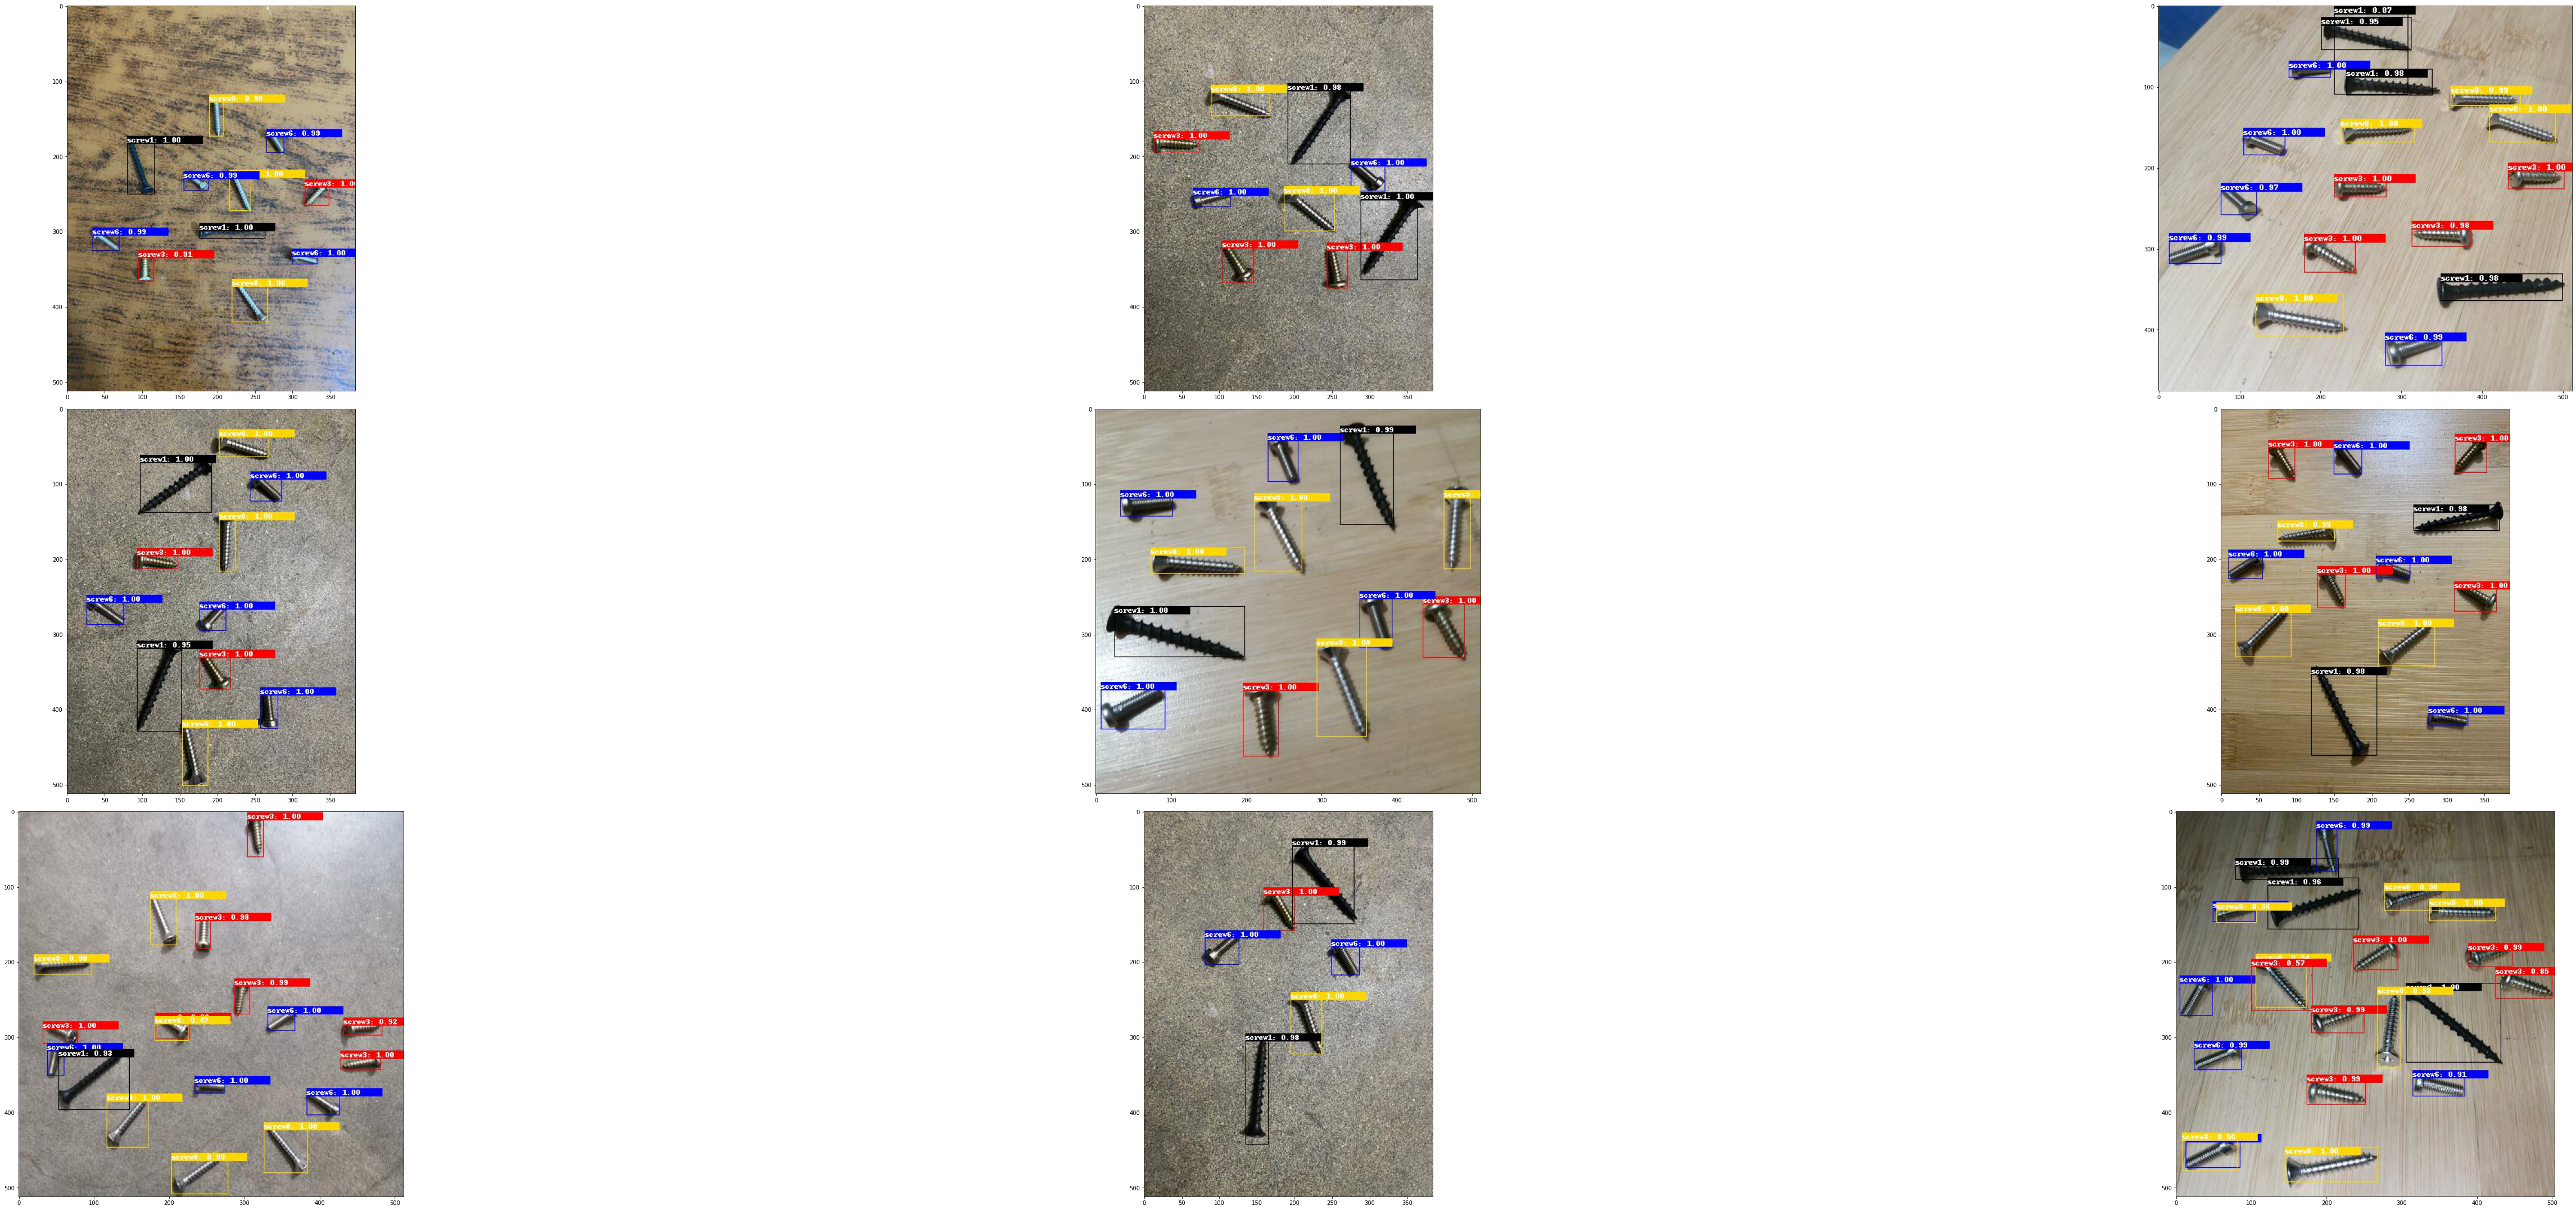

In [9]:
# Visualizing the sample images.
OUTPUT_PATH = 'yolo_infer_images' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)